In [1]:
import pandas as pd
import numpy as np


print("Setup Done")


Setup Done


In [2]:
# Load the csv file
df = pd.read_csv('FedEx_invoice.csv')

# Drop columns with null values of at least 20%
threshold = 0.8 * len(df)
df_cleaned = df.dropna(thresh=threshold, axis=1)

# Drop columns with only 1 unique value
df_cleaned = df_cleaned.loc[:, df_cleaned.nunique() > 1]

In [3]:
columns_list = df_cleaned.columns.tolist()
print(columns_list)

['Express or Ground Tracking ID', 'Transportation Charge Amount', 'Net Charge Amount', 'Service Type', 'Ground Service', 'Shipment Date', 'POD Delivery Date', 'Actual Weight Amount', 'Rated Weight Amount', 'Dim Length', 'Dim Width', 'Dim Height', 'Recipient City', 'Recipient State', 'Recipient Zip Code', 'Shipper City', 'Shipper State', 'Shipper Zip Code', 'Original Customer Reference', 'Original Recipient Address Line 1', 'Original Recipient City', 'Original Recipient State', 'Original Recipient Zip Code', 'Zone Code', 'Currency Conversion Date', 'Tendered Date', 'Tracking ID Charge Amount', 'Tracking ID Charge Amount.1', 'Tracking ID Charge Amount.3', 'Tracking ID Charge Amount.4']


In [4]:
# Drop 'Original Customer Reference' column coz it wont be used
# Drop 'Dim Length', 'Dim Width', 'Dim Height', 'Actual Weight Amount' columns since these values should have been factored in the Rated Weight Amount
columns_to_drop = ['Original Customer Reference', 'Dim Length', 'Dim Width', 'Dim Height', 'Actual Weight Amount']
df_cleaned.drop(columns=columns_to_drop, inplace=True)


amount_cols = ['Transportation Charge Amount', 'Rated Weight Amount', 'Tracking ID Charge Amount',
               'Tracking ID Charge Amount.1', 'Tracking ID Charge Amount.3', 'Tracking ID Charge Amount.4']

# Fill nulls in the amounts columns with the column's median value
for col in amount_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

date_cols = [col for col in df_cleaned.columns if 'Date' in col]

# Format Date column properly
for col in date_cols:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col].astype('Int64').astype(str), format='%Y%m%d', errors='coerce')

# Fill missing Tendered Dates with corresponding Shipment Date
df_cleaned['Tendered Date'] = df_cleaned['Tendered Date'].fillna(df_cleaned['Shipment Date'])

# Fill missing POD Delivery Date by adding the average elapsed days between POD Delivery Date and Shipment Date to the Shipment Date
df_cleaned['elapsed_days'] = (df_cleaned['POD Delivery Date'] - df_cleaned['Shipment Date']).dt.days
average_elapsed_days = np.ceil(df_cleaned['elapsed_days'].mean()).astype(int)
df_cleaned['POD Delivery Date'] = df_cleaned['POD Delivery Date'].fillna(df_cleaned['Shipment Date'] + pd.Timedelta(days=average_elapsed_days))
df_cleaned.drop(columns='elapsed_days', inplace=True)

# Fill missing Recipient Address Data using the Original Recipient Data
df_cleaned['Recipient City'] = df_cleaned['Recipient City'].fillna(df_cleaned['Original Recipient City'])
df_cleaned['Recipient State'] = df_cleaned['Recipient State'].fillna(df_cleaned['Original Recipient State'])
df_cleaned['Recipient Zip Code'] = df_cleaned['Recipient Zip Code'].fillna(df_cleaned['Original Recipient Zip Code'])

In [5]:
# Check whether there are still missing values
nan_count = df_cleaned.isnull().sum()
print(nan_count[nan_count > 0])

Series([], dtype: int64)


In [6]:

def classify_weight(weight):
    if weight <= 5:
        return 'Below 5'
    elif weight <= 10:
        return 'Between 5 and 10'
    elif weight <= 20:
        return 'Between 10 and 20'
    elif weight <= 50:
        return 'Between 20 and 50'
    elif weight <= 100:
        return 'Between 50 and 100'
    else:
        return 'Above 100'

# Adding Weight Class column by applying the classify_weight function
df_cleaned['Weight Class'] = df_cleaned['Rated Weight Amount'].apply(classify_weight)
# Convert Zone Code into Strings
df_cleaned['Zone Code'] = df_cleaned['Zone Code'].astype(str)

In [7]:
# Check the dataframe shape
print(df_cleaned.shape)

(4000, 26)


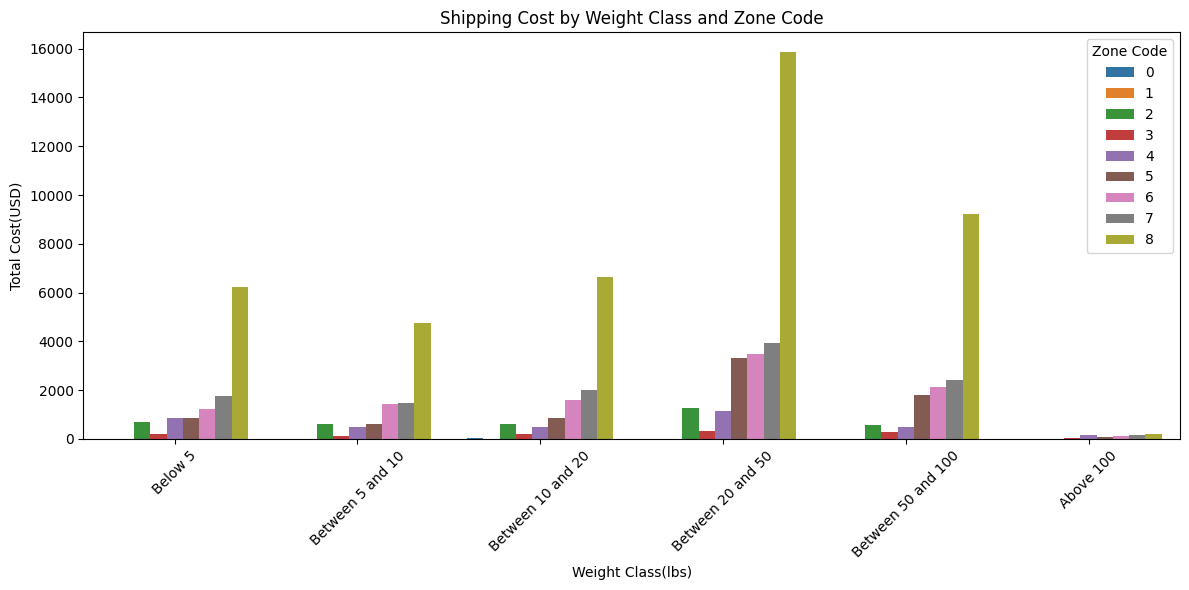

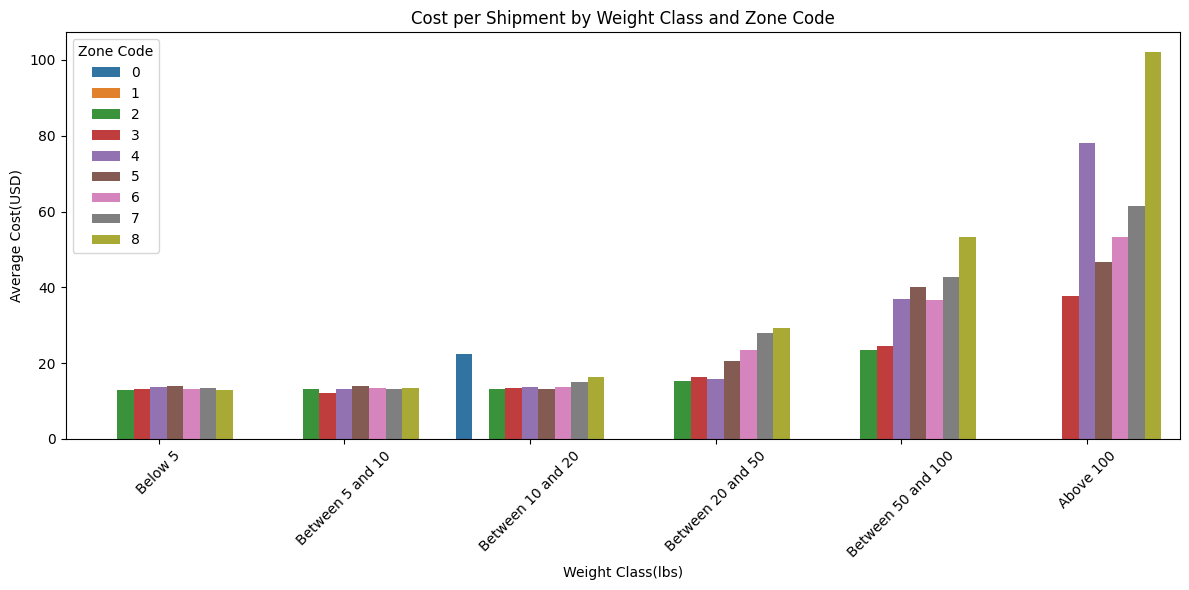

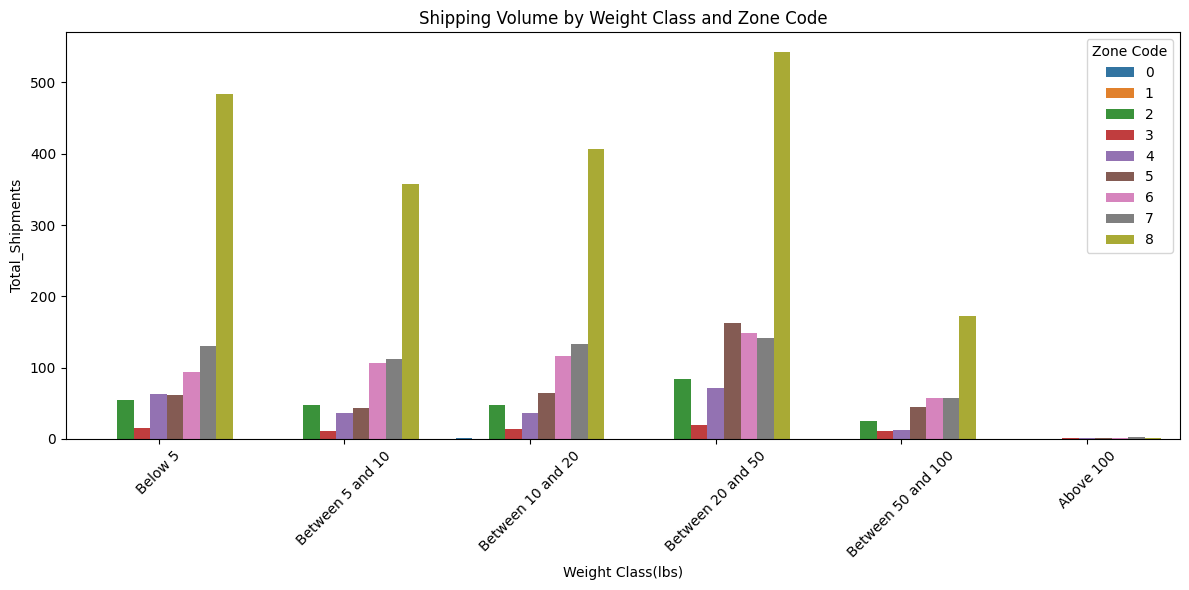

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the cleaned data by Weight Class and by Zone Code
grouped = df_cleaned.groupby(['Weight Class', 'Zone Code']).agg(
    Total_Shipments=('Express or Ground Tracking ID', 'count'),
    Total_Cost=('Net Charge Amount', 'sum'),
    Average_Cost=('Net Charge Amount', 'mean')
).reset_index()


weight_class_order = ['Below 5','Between 5 and 10', 'Between 10 and 20', 'Between 20 and 50', 'Between 50 and 100', 'Above 100']
zone_order = ['0','1','2','3','4','5','6','7','8']

# Generate charts

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Weight Class', y='Total_Cost', hue='Zone Code', hue_order=zone_order, order=weight_class_order)
plt.title('Shipping Cost by Weight Class and Zone Code')
plt.ylabel('Total Cost(USD)')
plt.xlabel('Weight Class(lbs)')
plt.xticks(rotation=45)
plt.legend(title='Zone Code')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Weight Class', y='Average_Cost', hue='Zone Code', hue_order=zone_order, order=weight_class_order)
plt.title('Cost per Shipment by Weight Class and Zone Code')
plt.ylabel('Average Cost(USD)')
plt.xlabel('Weight Class(lbs)')
plt.xticks(rotation=45)
plt.legend(title='Zone Code')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Weight Class', y='Total_Shipments', hue='Zone Code', hue_order=zone_order, order=weight_class_order)
plt.title('Shipping Volume by Weight Class and Zone Code')
plt.ylabel('Total_Shipments')
plt.xlabel('Weight Class(lbs)')
plt.xticks(rotation=45)
plt.legend(title='Zone Code')
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter

# Define weight class and zone order
weight_class_order = ['Below 5', 'Between 5 and 10', 'Between 10 and 20', 'Between 20 and 50', 'Between 50 and 100', 'Above 100']
zone_order = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter('shipping_analysis.xlsx', engine='xlsxwriter') as writer:
    # Write the Raw and Cleaned data to Excel File
    df.to_excel(writer, sheet_name='Raw Data', index=False)
    df_cleaned.to_excel(writer, sheet_name='Cleaned Data', index=False)
    # Write the grouped DataFrame to the Excel file
    grouped.to_excel(writer, sheet_name='Grouped Data', index=False)


    # Function to create and save a chart
    def create_and_save_chart(sheet_name, chart_title, y_column):
        plt.figure(figsize=(12, 6))
        sns.barplot(data=grouped, x='Weight Class', y=y_column, hue='Zone Code', hue_order=zone_order, order=weight_class_order)
        plt.title(chart_title)
        plt.ylabel(f'{chart_title.split()[0]} (USD)')
        plt.xlabel('Weight Class (lbs)')
        plt.xticks(rotation=45)
        plt.legend(title='Zone Code')
        plt.tight_layout()

        # Save the figure as a PNG file
        image_file = f'{y_column}_chart.png'
        plt.savefig(image_file)
        plt.close()

        # Create a new worksheet for the chart
        worksheet = writer.book.add_worksheet(sheet_name)
        worksheet.insert_image('E2', image_file)

    # Create and save each chart in a separate sheet
    create_and_save_chart('Shipping Cost', 'Shipping Cost by Weight Class and Zone Code', 'Total_Cost')
    create_and_save_chart('Average Cost', 'Cost per Shipment by Weight Class and Zone Code', 'Average_Cost')
    create_and_save_chart('Shipping Volume', 'Shipping Volume by Weight Class and Zone Code', 'Total_Shipments')

# The Excel file 'shipping_analysis.xlsx' now contains the data and charts in separate sheets.